# MACHINE LEARNING OLS

In [40]:
#Importing libaries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy import stats
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge


In [3]:
#Importing data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)
csv_file_path = '../Modeldata/data_ready_udenkom.csv'
df_final = pd.read_csv(csv_file_path)
df_final
df_final.set_index('Unnamed: 0', inplace=True)
df_final.index.name = None
print(len(df_final))

19848


In [4]:
##Deleting observations with less than 20 m2 -> To avoid "non-appartments"
outliers_m2 = df_final[(df_final['m2'] < 20) | ((df_final['m2'] < 50) & (df_final['Boligtype_Landejendom'] == 1))]
#print(outliers_m2)
df_final = df_final.drop(outliers_m2.index)

#Square meter price:
df_final['price/m2'] = df_final['Price']/df_final['m2']

print(len(df_final))
########################################################################
# Calculate Z-scores for each value in the column
df_final['z_score_price_m2'] = stats.zscore(df_final['price/m2'])

# Define outliers as any points with a Z-score > 4 or < -4
outliers = df_final[(df_final['z_score_price_m2'] > 3) | (df_final['z_score_price_m2'] < -3)]
#print(outliers.sort_values(by='price/m2', ascending=False))

df_final = df_final.drop(outliers.index)
df_final.drop(columns='price/m2', inplace=True)
########################################################################
# Calculate Z-scores for m2
df_final['z_score_m2'] = stats.zscore(df_final['m2'])

# Define outliers as any points with a Z-score > 4 or < -4
outliers_m2 = df_final[(df_final['z_score_m2'] > 3) | (df_final['z_score_m2'] < -3)]
#print(outliers_m2.sort_values(by='m2', ascending=True))
print(len(outliers_m2))
df_final = df_final.drop(outliers_m2.index)
print(len(df_final))

########################################################################

#Calculate Z-scores for price
df_final['z_score_price'] = stats.zscore(df_final['Price'])
# Define outliers as any points with a Z-score > 4 or < -4
outliers_price = df_final[(df_final['z_score_price'] > 3) | (df_final['z_score_price'] < -3)]
#print(outliers_m2.sort_values(by='m2', ascending=True))
df_final = df_final.drop(outliers_price.index)


print(len(df_final))

df_final = df_final.drop('z_score_m2', axis=1)
df_final = df_final.drop('z_score_price_m2', axis=1)
df_final = df_final.drop('z_score_price', axis=1)


#print(df_final.sort_values(by='price/m2', ascending=True))

19845
253
19278
18861


In [5]:
y = df_final['Price']
X = df_final.drop(columns=['Price'])

In [6]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=42) #The random_state works as a seed

#2
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

In [7]:
# DEFINE PIPELINE
pipe_lr = make_pipeline(PolynomialFeatures(degree=1), 
                        StandardScaler(),
                        LinearRegression())

# FIT PIPELINE TO DEVELOPMENT DATA
pipe_lr.fit(X_dev, y_dev)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

LinReg_MSE 1488586360216.93
LinReg_MAE 882083.85
LinReg_MAPE 0.81
LinReg_RMSE 1220076.3747474689
LinReg_r2 0.6100684098778397


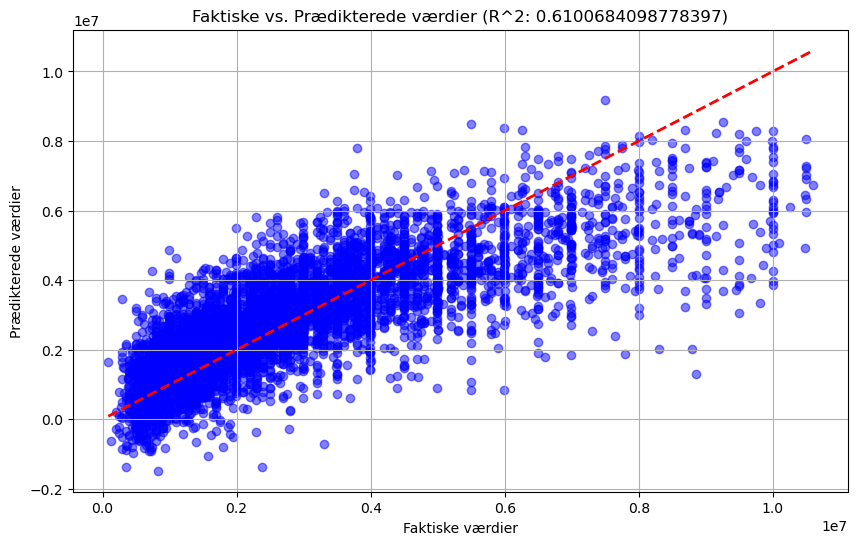

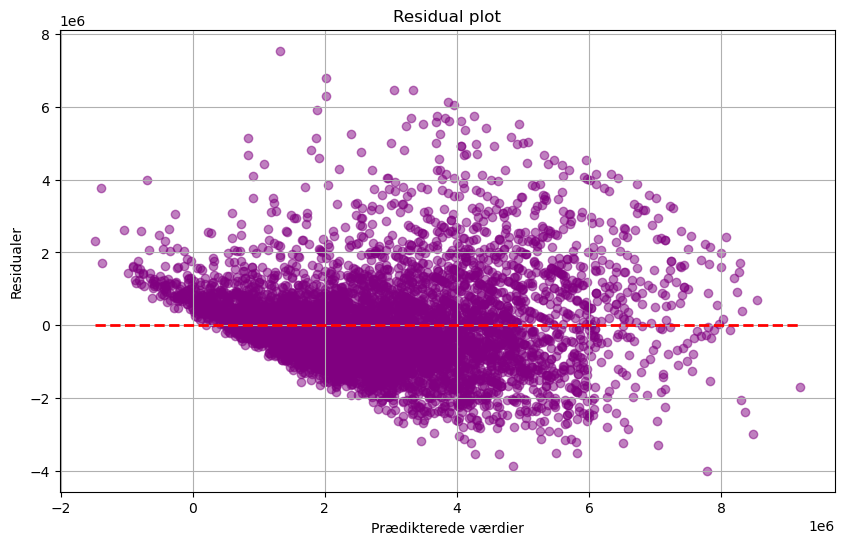

In [8]:
y_predict_lr_degree_1 = pipe_lr.predict(X_test)
print('LinReg_MSE', round(mse(y_predict_lr_degree_1,y_test), 2))
print('LinReg_MAE', round(mean_absolute_error(y_predict_lr_degree_1, y_test), 2))
print('LinReg_MAPE', round(mean_absolute_percentage_error(y_predict_lr_degree_1, y_test), 2))
print('LinReg_RMSE', np.sqrt(mse(y_predict_lr_degree_1, y_test)))
print('LinReg_r2', r2_score(y_test, y_predict_lr_degree_1))
linear_model = pipe_lr.named_steps['linearregression']
coeff = linear_model.coef_

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict_lr_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_predict_lr_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_predict_lr_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_predict_lr_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_predict_lr_degree_1.min(), y_predict_lr_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


In [9]:
print('Koefficienter:', coeff)

Koefficienter: [ 2.12651477e-04 -1.43839590e+05  2.89777632e+04 -3.21858284e+04
  1.01808055e+05 -6.47578989e+04  6.40196922e+05  2.48207511e+05
 -9.32103982e+03  7.86914357e+04  4.86725709e+04  1.87216548e+05
  7.48616161e+02  2.79484685e+04  4.92865984e+04  5.67142186e+06
 -4.90083489e+06  5.09226068e+05 -1.66669339e+05 -3.00793270e+05
 -2.03969916e+08 -7.08967837e+07 -1.56429879e+08 -1.99640182e+05
  3.36576165e+05  2.83011360e+04  2.86513871e+05  8.55170399e+04
  1.37032149e+05 -9.67467338e+04  2.64230876e+04  4.70536713e+04
  3.93737950e+04  1.73992962e+05  4.74989176e+04  1.41490909e+05
 -1.43800072e+04 -9.11870371e+04  7.60466487e+04  2.82182513e+03
  1.33582006e+05  4.49227949e+03 -3.35732852e+04  1.07658854e+05
 -2.85125093e+05 -2.40627402e+04 -9.12776691e+04  2.40681195e+04
  2.68142394e+04  7.20143188e+03  1.76665890e+05  3.08289912e+05
  1.83968367e+05  1.40872623e+05  9.13119499e+04 -5.35435438e+02
 -2.42113105e+04 -2.78240089e+04  7.81338155e+04  9.14887252e+04
  7.077432

In [10]:
# Initializing Linear-regression-model with degree=2
from sklearn.linear_model import Lasso, LinearRegression

# DEFINE PIPELINE
pipe_lr = make_pipeline(PolynomialFeatures(degree=2), 
                        StandardScaler(),
                        LinearRegression())

# FIT PIPELINE TO DEVELOPMENT DATA
pipe_lr.fit(X_dev, y_dev)

"""
scaler = StandardScaler()
X_dev2 = scaler.fit_transform(X_dev)
X_test2 = scaler.transform(X_test)

ols_model_scaled = LinearRegression()

ols_model_scaled.fit(X_dev2, y_train)

y_pred_ols_scaled = ols_model_scaled.predict(X_test2)
y_pred_ols_train = ols_model_scaled.predict(X_dev2)

ols_mse_scaled = mse(y_test, y_pred_ols_scaled)
ols_r2_scaled = r2_score(y_test, y_pred_ols_scaled)
"""


'\nscaler = StandardScaler()\nX_dev2 = scaler.fit_transform(X_dev)\nX_test2 = scaler.transform(X_test)\n\nols_model_scaled = LinearRegression()\n\nols_model_scaled.fit(X_dev2, y_train)\n\ny_pred_ols_scaled = ols_model_scaled.predict(X_test2)\ny_pred_ols_train = ols_model_scaled.predict(X_dev2)\n\nols_mse_scaled = mse(y_test, y_pred_ols_scaled)\nols_r2_scaled = r2_score(y_test, y_pred_ols_scaled)\n'

In [11]:
y_predict = pipe_lr.predict(X_test)
print('LinReg_MSE', round(mse(y_predict,y_test), 2))
print('LinReg_MAE', round(mean_absolute_error(y_predict, y_test), 2))
print('LinReg_MAPE', round(mean_absolute_percentage_error(y_predict, y_test), 2))
print('LinReg_RMSE', np.sqrt(mse(y_predict, y_test)))
print('LinReg_r2', r2_score(y_test, y_predict))

"""
y_test_pred_linreg = pipe_lr.predict(X_test)
r2_score_linereg = r2_score(y_test, y_test_pred_linreg)
print(r2_score_linereg)
"""

LinReg_MSE 6.940275074494046e+30
LinReg_MAE 49276156743616.62
LinReg_MAPE 2.24
LinReg_RMSE 2634440182371588.0
LinReg_r2 -1.8179882390486833e+18


'\ny_test_pred_linreg = pipe_lr.predict(X_test)\nr2_score_linereg = r2_score(y_test, y_test_pred_linreg)\nprint(r2_score_linereg)\n'

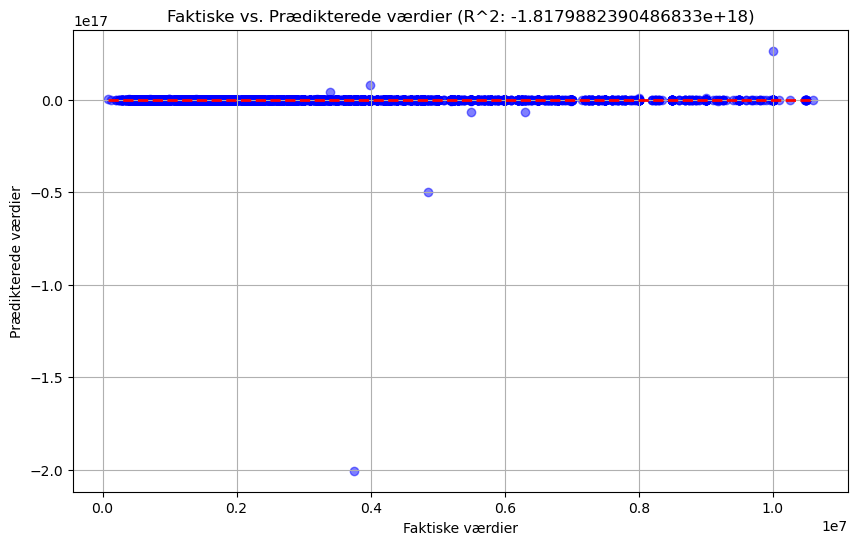

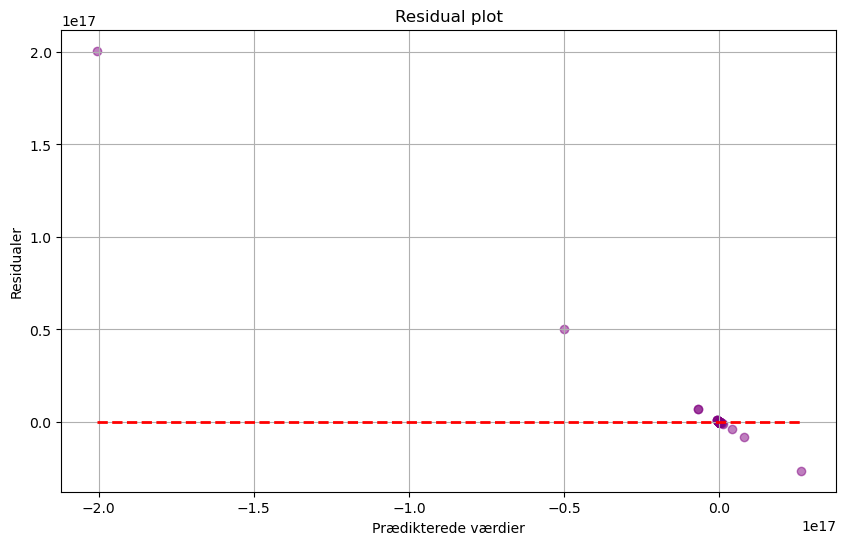

In [12]:
# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_predict)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_predict

plt.figure(figsize=(10, 6))
plt.scatter(y_predict, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_predict.min(), y_predict.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()



# Lasso-model, degree=1 and no Cross-validation

In [14]:
# Initialize Lasso-model with degree=1, CV=0
from sklearn.metrics import mean_squared_error as mse

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(0, 7, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=42))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 1.0
Validation MSE: 1447452946189.960


In [15]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()), ('lasso', Lasso())])

Lasso_MSE_de1 1488738398806.95
Lasso_MAE_de1 881196.93
Lasso_MAPE_de1 0.87
Lasso_RMSE_de1 1220138.6801535913
Lasso_R2_de1 0.6100285837375823


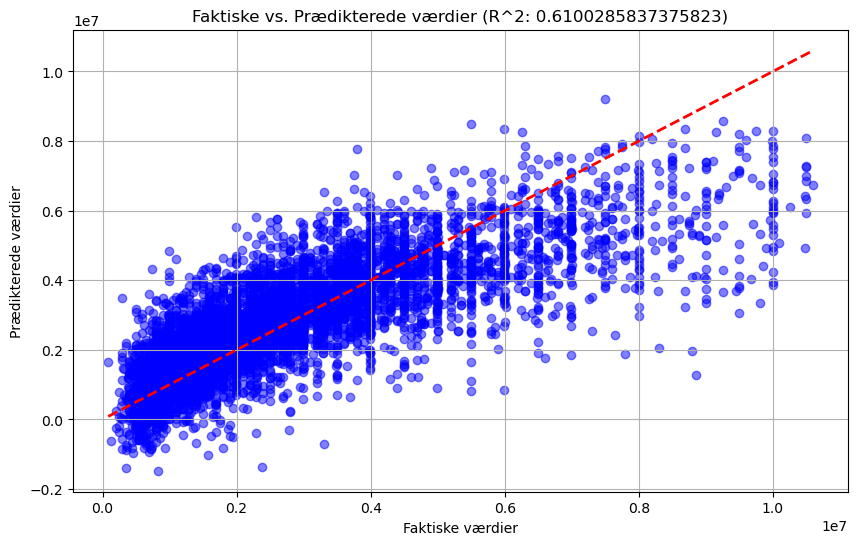

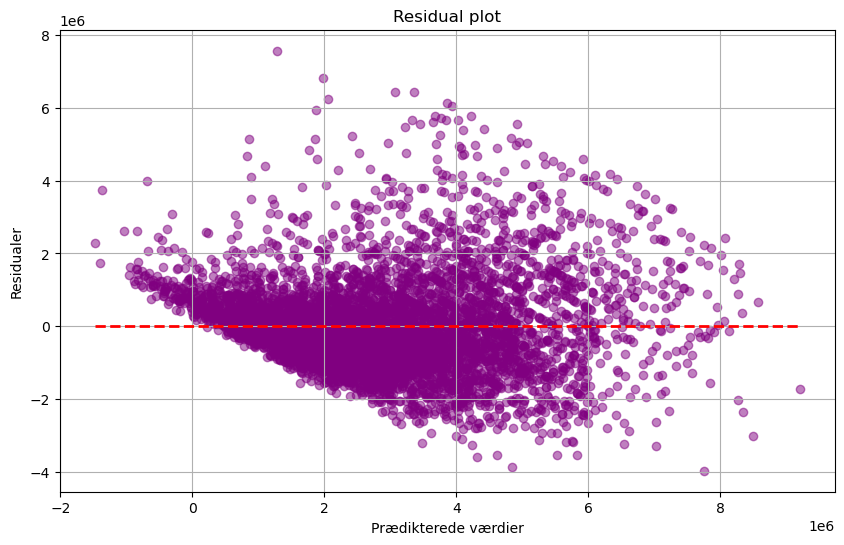

In [16]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_0 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de1', round(mse(y_test_pred_lasso_degree_0,y_test), 2))
print('Lasso_MAE_de1', round(mean_absolute_error(y_test_pred_lasso_degree_0, y_test), 2))
print('Lasso_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_0, y_test), 2))
print('Lasso_RMSE_de1', np.sqrt(mse(y_test_pred_lasso_degree_0, y_test)))
print('Lasso_R2_de1', r2_score(y_test, y_test_pred_lasso_degree_0))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_0, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_0)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_0

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_0, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_0.min(), y_test_pred_lasso_degree_0.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# LASSO-MODEL MED DEGREE=2 and no Cross-validation

In [18]:
# Initialize Lasso-model with degree=2, CV=0
from sklearn.metrics import mean_squared_error as mse

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(0, 7, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=42))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 26024.633095283836
Validation MSE: 1216609073792.842


In [19]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=26024.633095283836))])

Lasso_MSE_de2 1231346172219.6
Lasso_MAE_de2 783013.5
Lasso_MAPE_de2 0.43
Lasso_RMSE_de2 1109660.3859828445
Lasso_R2_de2 0.6774518538148815


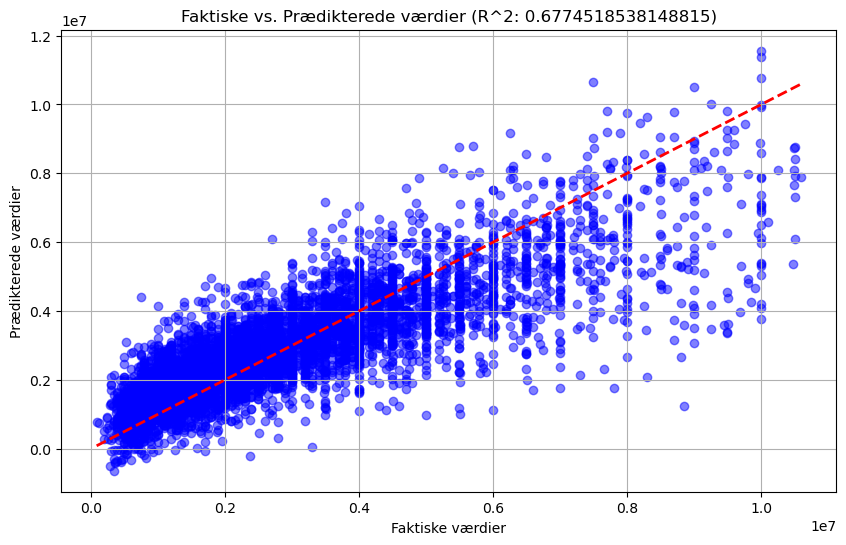

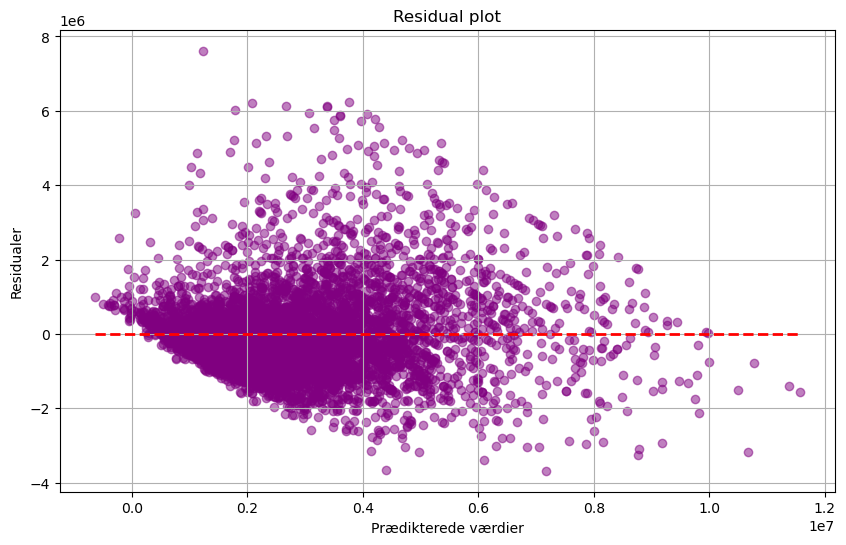

In [20]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_0 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de2', round(mse(y_test_pred_lasso_degree_0,y_test), 2))
print('Lasso_MAE_de2', round(mean_absolute_error(y_test_pred_lasso_degree_0, y_test), 2))
print('Lasso_MAPE_de2', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_0, y_test), 2))
print('Lasso_RMSE_de2', np.sqrt(mse(y_test_pred_lasso_degree_0, y_test)))
print('Lasso_R2_de2', r2_score(y_test, y_test_pred_lasso_degree_0))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_0, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_0)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_0

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_0, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_0.min(), y_test_pred_lasso_degree_0.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# RIDGE MODEL, degree = 1, CV=0

Optimal lambda: 1.0
Validation MSE: 1447844710990.847


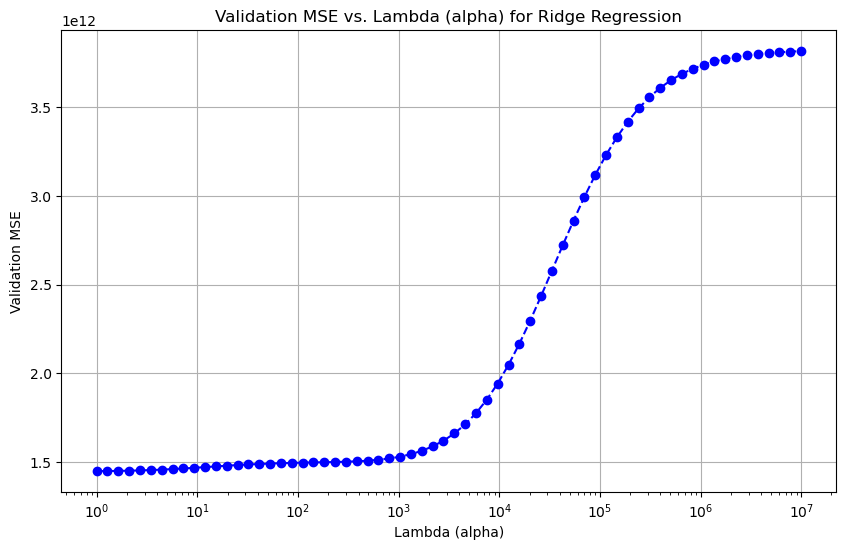

In [66]:
#Initialize the Ridge-model with degree = 1 and cv = 0
# Initialize Lasso-model with degree=2, CV=0

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(0, 7, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=42))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()



In [58]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Ridge(alpha=optimal.values[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=1447844710990.847))])

Ridge_MSE_de1 3819747523693.7
Ridge_MAE_de1 1516079.68
Ridge_MAPE_de1 0.52
Ridge_RMSE_de1 1954417.438443923
Ridge_R2_de1 -0.0005736083474661147


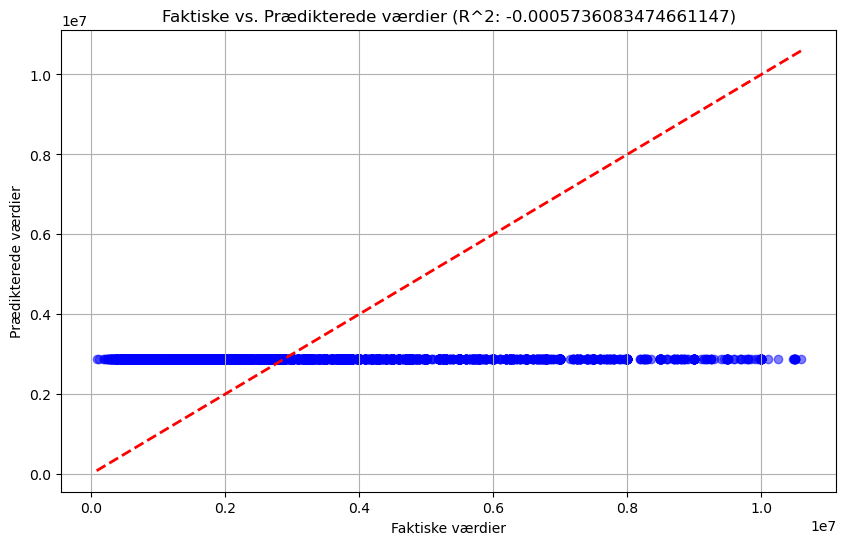

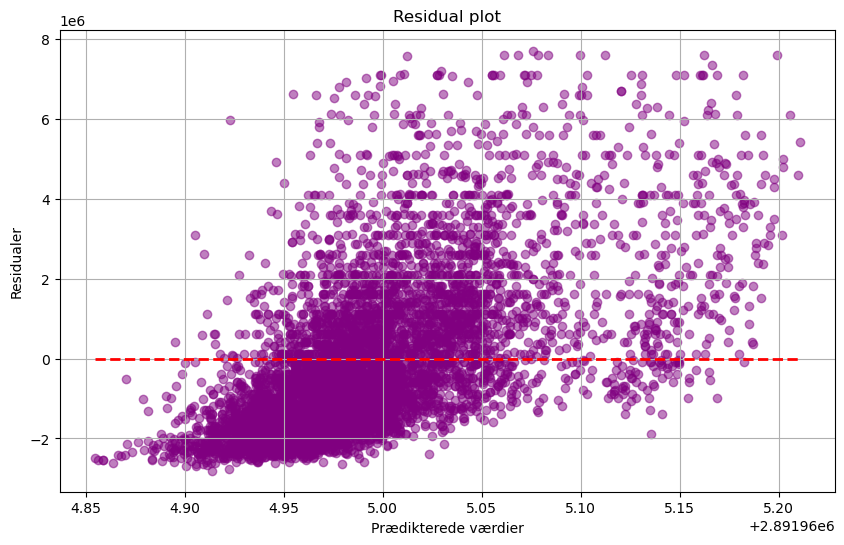

In [64]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_0 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de1', round(mse(y_test_pred_ridge_degree_0,y_test), 2))
print('Ridge_MAE_de1', round(mean_absolute_error(y_test_pred_ridge_degree_0, y_test), 2))
print('Ridge_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_0, y_test), 2))
print('Ridge_RMSE_de1', np.sqrt(mse(y_test_pred_ridge_degree_0, y_test)))
print('Ridge_R2_de1', r2_score(y_test, y_test_pred_ridge_degree_0))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_0, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_0)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_0

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_0, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_0.min(), y_test_pred_ridge_degree_0.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

# RIDGE, degree=2, CV=0